# Evaluate Partial Charge Prediction
Test how well our models for partial charges are working

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.mpnn import set_custom_objects, run_model
from jcesr_ml.benchmark import load_benchmark_data
from sklearn.metrics import mean_absolute_error
from keras.models import load_model
from ase.units import eV, Hartree
from time import perf_counter
from rdkit.Chem import AllChem
from rdkit import Chem
from pathlib import Path
from tqdm import tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import torch
import json
import os

Using TensorFlow backend.


In [2]:
set_custom_objects()

## Load in Datasets
We need the datasets for determining the shape of the inputs

In [3]:
test_data = pd.read_pickle('mapped_charges_dataset.pkl.gz')

In [4]:
test_data.query('in_holdout', inplace=True)

## Get Baselines
See how good assuming all networks to be uncharged is.

In [5]:
charge_mae = test_data['atomic_charges'].apply(np.array).apply(np.abs).apply(sum).sum() / test_data['n_atom'].sum()
print(f'MAE of all charges {charge_mae: .2f}')

MAE of all charges  0.19


Estimate partial charges with [Gasteiger Charges](https://www.rdkit.org/docs/source/rdkit.Chem.rdPartialCharges.html)

In [6]:
def compute_gasteiger_charges(smiles):
    """Compute the Gasteiger partial charges for a molecule
    
    Args:
        smiles (str): SMILES string of the molecule
    Returns:
        (ndarray) Charges on each atom
    """
    
    # Parse the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    # Compute the charges
    AllChem.ComputeGasteigerCharges(mol)
    
    # Extract the charges
    return np.array([float(atom.GetProp('_GasteigerCharge')) for atom in mol.GetAtoms()])

In [7]:
%%time
test_data['gasteiger_charges'] = test_data['smiles_0'].apply(compute_gasteiger_charges)

CPU times: user 6.15 s, sys: 6.13 ms, total: 6.16 s
Wall time: 6.16 s


In [8]:
gasteiger_charges_mae = mean_absolute_error(np.hstack(test_data['gasteiger_charges']), np.hstack(test_data['mapped_charges']))
print(f'Gastier MAE: {gasteiger_charges_mae:.3f}')

Gastier MAE: 0.124


## Evaluate All Models
See if our deep learning model is better than the Gasteiger partial charges

In [9]:
models = glob(os.path.join('networks', '**', 'best_model.h5'), recursive=True)

In [10]:
def score_model(path):
    """Given a log file, parse the settings for the network and the epoch time / ending val_loss
    
    Args:
        path (str): Get the path 
    """
    
    # Get the metadata from directory structure
    path = Path(path)
    parents = list(path.parents)
    metadata = [p.name for p in parents[:-3]]
    metadata = dict([(x[-1], '-'.join(x[:-1])) for x in map(lambda x: x.split("-"), metadata)])
    metadata['path'] = str(path.parent)
    metadata['network'] = parents[-3].name
    
    # Convert numerical values
    for k in ['nodes', 'entries', 'batch_size']:
        metadata[k] = int(metadata[k])
    
    # Score the model on the target variable
    with open(parents[-3].joinpath('options.json')) as fp:
        options = json.load(fp)
    output = options['output_props']
    metadata['output'] = output
    
    # Load in the log
    log = pd.read_csv(path.parent.joinpath('log.csv'))
    metadata['epochs'] = len(log)
    metadata['median_epoch_time'] = np.percentile(log['epoch_time'], 50)
    metadata['total_time'] = log['epoch_time'].sum()
    metadata['cpu-hrs'] = metadata['total_time'] * metadata['nodes'] / 3600 * 64
    metadata['best_loss'] = log['val_loss'].min()
    metadata['best_loss_epoch'] = log['val_loss'].idxmin()
    
    # Check whether the network had finished training
    metadata['finished'] = os.path.isfile(path.parent.joinpath('finished'))
    
    # Load the converter
    with open(parents[-3].joinpath('converter.pkl'), 'rb') as fp:
        converter = pkl.load(fp)
    
    # Load in the model and run it on the test set
    directory = path.parent
    y_true = np.hstack(test_data['mapped_charges'])
    for name in ['best_model.h5', 'checkpoint.h5']:
        tag = '-best' if name.startswith('best') else '-last'
        
        model = load_model(str(path.parent.joinpath(name)))
        start_time = perf_counter()
        y_pred = np.squeeze(run_model(model, converter, test_data['smiles_0'], chunk_size=1024))
        metadata[f'mae{tag}'] = mean_absolute_error(y_pred, y_true)
        metadata[f'eval_time{tag}'] = perf_counter() - start_time
        
    return metadata

In [11]:
results = pd.DataFrame([score_model(m) for m in tqdm(models) if 'standard' in m])

  0%|          | 0/3 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/home/lward/miniconda3/envs/jcesr_ml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lward/miniconda3/envs/jcesr_ml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 33%|███▎      | 1/3 [00:22<00:45, 22.88s/it]/home/lward/miniconda3/envs/jcesr_ml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lward/miniconda3/envs/jcesr_

In [12]:
results[['network', 'learning_rate', 'batch_size', 'mae-best', 'mae-last', 'cpu-hrs', 'total_time']]

,network,learning_rate,batch_size,mae-best,mae-last,cpu-hrs,total_time
0,standard,1.00e-04,1024,0.016461,0.017548,110.938707,6240.302262
1,standard,1.00e-04,8192,0.008406,0.010044,4788.905113,33671.989076


## Plot the Convergence Curve
See if the network is converged. Or at least close to it

In [13]:
best_model = results.sort_values('mae-best', ascending=True).iloc[0]

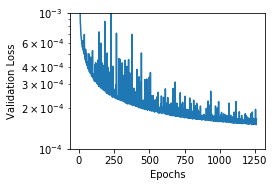

In [14]:
log = pd.read_csv(os.path.join(best_model.path, 'log.csv'))
fig, ax = plt.subplots()

ax.semilogy(log['epoch'], log['val_loss'])
ax.set_ylim(1e-4, 1e-3)

ax.set_xlabel('Epochs')
ax.set_ylabel('Validation Loss')
fig.set_size_inches(3.5, 2.5)

## Save the Ouputs
We need to save the ouputs in a lookup table format so that they can be used in a machine learning model's data loaders.

In [15]:
all_data = pd.concat(load_benchmark_data())

Save the Gasteiger charges

In [16]:
%%time
gasteiger_charges = dict(zip(all_data['smiles_0'], all_data['smiles_0'].apply(compute_gasteiger_charges)))

CPU times: user 1min 5s, sys: 357 ms, total: 1min 5s
Wall time: 1min 5s


In [17]:
filename = 'gasteiger-charges.pkl'
if os.path.isfile(filename):
    print('Skipping. Will not overwrite lookup table')
else:
    with open('gasteiger-charges.pkl', 'wb') as fp:
        pkl.dump(gasteiger_charges, fp)

Save the MPNN-computed charges

In [18]:
model = load_model(os.path.join(best_model.path, 'best_model.h5'))

/home/lward/miniconda3/envs/jcesr_ml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [19]:
with open(os.path.join('networks', best_model.network, 'converter.pkl'), 'rb') as fp:
    converter = pkl.load(fp)

In [20]:
def compute_mpnn_charges(model, converter, test_data, chunk_size=1024):
    """Compute the chargest for all molecules in a dataset
    
    Args:
        test_data (DataFrame): Dataset to evalaute
        chunk_size (int): How many chargest to evaluate at once
    Returns:
        ([ndarray]): Charges for each molecule
    """
    
    # Get the predicted charges
    y_pred = np.squeeze(run_model(model, converter, test_data['smiles_0'], chunk_size=1024))
    
    # Break up by molecule
    return np.split(y_pred, test_data['n_atom'].cumsum())[:-1]

In [21]:
%%time
mpnn_charges = compute_mpnn_charges(model, converter, all_data)

CPU times: user 41min 36s, sys: 5min 8s, total: 46min 44s
Wall time: 1min 6s


In [22]:
mpnn_charges = dict(zip(all_data['smiles_0'], mpnn_charges))

In [23]:
filename = 'mpnn-charges.pkl'
if os.path.isfile(filename):
    print('Skipping. Will not overwrite lookup table')
else:
    with open(filename, 'wb') as fp:
        pkl.dump(mpnn_charges, fp)